In [1]:
from google.colab import drive

import tensorflow as tf
import pathlib

import matplotlib.pyplot as plt
drive.mount('/content/drive/')

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn import svm
from sklearn import inspection


Mounted at /content/drive/


In [2]:
zip_path = 'file:///content/drive/MyDrive/DPL302m/4animals/Dataset.rar'
archive = tf.keras.utils.get_file(origin =zip_path, extract =True)
data_dir = pathlib.Path(archive).with_suffix('')

287892265/287892265 [==============================] - 6s 0us/step


In [3]:
print(data_dir)

/root/.keras/datasets/Dataset


In [4]:
!pip install unrar
!unrar x /root/.keras/datasets/Dataset.rar

Streaming output truncated to the last 5000 lines.
Extracting  Dataset/dogs/OIP-FTlEFZW1FKCi1lDzCKps6AHaFj.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-FTq-KMrwf0NFqTUlrR_u1QEsDh.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-fUB4o4VwpYi686vKuVT7FgHaFj.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-FUcOvcfngNRNfZ1s7o7xmAHaFj.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-fUdUcL6uWwAlv7dC-4o4JAHaE6.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-fUoYXvxGN9HzHbD5MG3G1gHaEo.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-Fv-k9hTtP1R0rnLLkq6r0QHaNK.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-fva2NLIFwSbsvTEiPJtHuwHaFH.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-FvgpojFeqSCMibMFCyqPQgHaJ4.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-FvuKTja7LBCOKLCi0VHIGQHaFc.jpeg              77%  OK 
Extracting  Dataset/dogs/OIP-

In [5]:
extracted_path = '/content/Dataset'

In [6]:
#load file to train dataset and validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    extracted_path,
    validation_split=0.1,
    subset ='training',
    seed=42,
    image_size = (224,224),
    batch_size =32
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    extracted_path,
    validation_split=0.1,
    subset='validation',
    seed=42,
    image_size=(224,224),
    batch_size=32
)

Found 11491 files belonging to 4 classes.
Using 10342 files for training.
Found 11491 files belonging to 4 classes.
Using 1149 files for validation.


In [7]:
#check for classes in dataset
print('class in train dataset:',train_ds.class_names)
print('class in validation dataset:', valid_ds.class_names)

class in train dataset: ['cats', 'chicken', 'dogs', 'squirrels']
class in validation dataset: ['cats', 'chicken', 'dogs', 'squirrels']


In [11]:
#augmentation image before fit into model
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
valid_ds = valid_ds.map(lambda x, y: (preprocess_input(x), y))

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size = AUTOTUNE)

In [13]:
model = MobileNet(input_shape=(224,224,3), include_top=True)
model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [14]:
vector = model.get_layer("reshape_2").output
feature_extractor = tf.keras.Model(model.input, vector)

In [49]:
for images, labels in valid_ds:
  print(images.shape)
  break

(32, 224, 224, 3)


In [50]:
X = []
Y = []
features_=[]
for images, labels in valid_ds:
  feature_vec = feature_extractor.predict(images)
  features_.append(feature_vec.shape)
  X.append(feature_vec.ravel())
  Y.append(labels)

1/1 [==============================] - 0s 35ms/step


In [51]:
features_

[(32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (32, 1000),
 (29, 1000)]

In [52]:
import numpy as np
from sklearn import model_selection
from sklearn.metrics import classification_report

In [60]:
X_new = np.concatenate([X[i] for i in range(len(X))], axis = 0)
Y_new = np.concatenate([Y[i] for i in range(len(Y))], axis = 0)
X_new = np.asarray(X_new, dtype = np.float32)
Y_new = np.asarray(Y_new, dtype = np.float32)

In [62]:
X_new = X_new.reshape(-1, 1000)

In [63]:
print(X_new.shape)
print(Y_new.shape)

(1149, 1000)
(1149,)


In [67]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_new, Y_new, test_size=0.2, random_state=42, shuffle=True)

In [68]:
y_train.shape

(919,)

In [75]:
from sklearn import decomposition

In [76]:
pca = decomposition.PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [77]:
svm_model = svm.SVC(C=1.0, kernel="rbf")
svm_model.fit(X_train_pca, y_train)
y_pred = svm_model.predict(X_test_pca)
print(classification_report(y_test, y_pred,target_names=['cats', 'chicken', 'dogs', 'squirrels']))

              precision    recall  f1-score   support

        cats       0.86      0.86      0.86        42
     chicken       0.89      0.97      0.93        59
        dogs       0.93      0.92      0.93        91
   squirrels       0.97      0.87      0.92        38

    accuracy                           0.91       230
   macro avg       0.91      0.90      0.91       230
weighted avg       0.91      0.91      0.91       230



In [73]:
X_test.shape

(230, 1000)

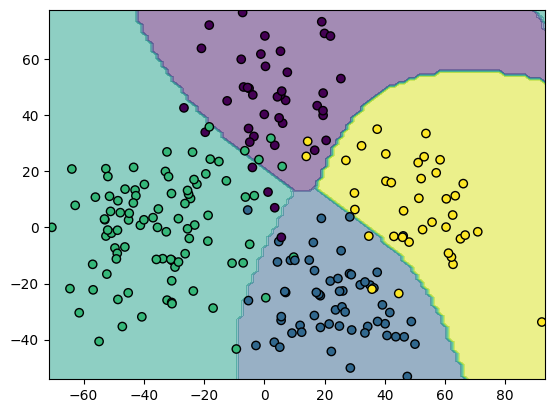

In [79]:
disp = inspection.DecisionBoundaryDisplay.from_estimator(
    svm_model,
    X=X_test_pca,
    response_method = 'predict',
    alpha=0.5
)
disp.ax_.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, edgecolor="k")